In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

%matplotlib inline

In [93]:
def synthetic_data():
    mean1 = np.concatenate((np.ones(1)*-10,np.ones(12)))
    mean2 =  np.concatenate((np.ones(12),np.ones(1)*10))
    mean3 = np.ones(13)*5
    mean4 = np.ones(13)*-5
    g1 = np.random.multivariate_normal(mean1, np.eye(13), size=55)
    g2 = np.random.multivariate_normal(mean2, np.eye(13), size=36)
    g3 = np.random.multivariate_normal(mean3, np.eye(13), size=35)
    g4 = np.random.multivariate_normal(mean4, np.eye(13), size=13)

    y1 = np.asarray([1]*55).reshape(55,1)
    y2 = np.asarray([2]*36).reshape(36,1)
    y3 = np.asarray([3]*35).reshape(35,1)
    y4 = np.asarray([4]*13).reshape(13,1)


    #y1 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y2 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y3 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y4 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)

    g1 = np.concatenate((g1,y1), axis=1)
    g2 = np.concatenate((g2,y2), axis=1)
    g3 = np.concatenate((g3,y3), axis=1)
    g4 = np.concatenate((g4,y4), axis=1)

    g = np.concatenate([g1,g2,g3,g4], axis=0)

    d = pd.DataFrame(data=g, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
    return d

#d1 = pd.DataFrame(data=g1, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d2 = pd.DataFrame(data=g2, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d3 = pd.DataFrame(data=g3, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d4 = pd.DataFrame(data=g4, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#plt.scatter(g1[:,0], g1[:,1],g1[:,2], c='b')
#plt.scatter(g2[:,0], g2[:,1],g2[:,2], c='r')
#plt.scatter(g3[:,0], g3[:,1],g3[:,2], c='g')
#plt.scatter(g4[:,0], g4[:,1],g4[:,2], c='y')
#plt.show()

In [167]:
def train_and_test(df):
    data = df
    ## split data into train and test
    cols = list(data.columns)
    cols.remove('num')
    target = data['num'].copy()
    input_data = data[cols].copy()
    #target_bin = label_binarize(target, classes=[0, 1, 2, 3, 4])
    #test removing healthy patients
    target_bin = label_binarize(target, classes=[1, 2, 3, 4])
    global targetTests
    dTrain, dTest, targetTrain, targetTest = train_test_split(input_data, target_bin, test_size=0.20, stratify=target_bin)
    targetTests.append(targetTest)
    #print(np.argmax(targetTrain, axis=1)+1)
    scaler = preprocessing.StandardScaler().fit(dTrain)
    dTrain = scaler.transform(dTrain)
    ovr = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0), n_jobs=-1)
    ovr.fit(dTrain, targetTrain)
    dTest = scaler.transform(dTest)
    probas = ovr.predict_proba(dTest)
    pred = ovr.predict(dTest)
    #print(np.argmax(pred, axis=1)+1)
    #print(np.argmax(targetTest, axis=1)+1)
    score = ovr.score(dTest, targetTest)
    targetTest_nonbin = np.asarray(np.argmax(targetTest, axis=1)+1)
    pred = np.asarray(np.argmax(pred, axis=1)+1)
    #cm = confusion_matrix(targetTest_nonbin, pred, labels=[0,1,2,3,4])
    #test removing healthy patients
    cm = confusion_matrix(targetTest_nonbin, pred, labels=[1,2,3,4])
    #score = np.sum(np.diagonal(cm))/np.sum(cm)
    np.savetxt("confusion_matrix_ova.csv", cm, delimiter=",")
    
    return score, probas

In [173]:
targetTests = []
scores = []
probas_final = []
iterations = 50
data = synthetic_data()
for i in tqdm(range(iterations)):
    score, probas = train_and_test(data)
    scores.append(score)
    probas_final.append(probas)
    
target = targetTests[np.argmax(scores)]
proba = probas_final[np.argmax(scores)]
scores = np.asarray(scores)
print(scores.mean())
print(scores.std())

100%|██████████| 50/50 [00:10<00:00,  5.04it/s]      | 1/50 [00:00<00:11,  4.38it/s]

1.0
0.0


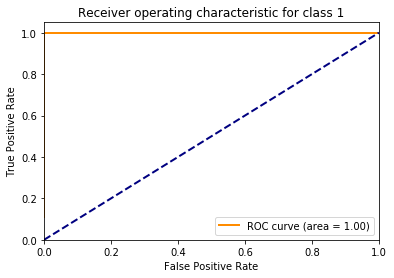

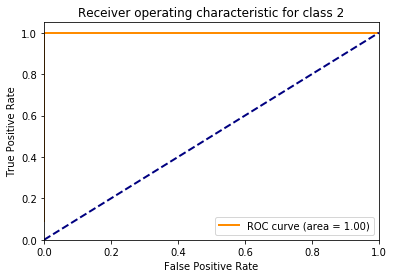

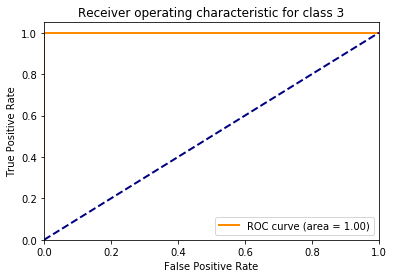

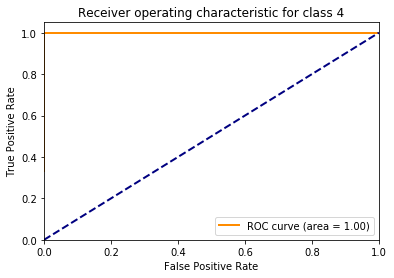

In [174]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#for i in range(5):
#test removing healthy patients
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(target[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#for i in range(5):
#test removing healthy patients
for i in range(4):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class ' + str(i+1))
    plt.legend(loc="lower right")

    plt.show()

In [172]:
ova = pd.read_csv('confusion_matrix_ova.csv', header=None)
print(ova)

     0     1    2    3
0  8.0   0.0  0.0  0.0
1  0.0  10.0  0.0  0.0
2  0.0   0.0  7.0  0.0
3  0.0   0.0  0.0  3.0
